In [1]:
# utils
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import random
import unidecode
import re
from datetime import datetime

# image
from PIL import Image, ImageFilter

# openCV
import cv2

# scikit learn
from skimage import io, util
from skimage.color import rgb2gray
from scipy import misc

# imgaug
import imgaug as ia
from imgaug import augmenters as iaa

# noise
import noise
from perlin import PerlinNoiseFactory

# ocr
import pytesseract

In [30]:
# loading test image
# img = cv2.imread('2.png')
img = cv2.imread('./is_ocr_images/740156_2590157_64.jpg')

In [172]:
# draw a randomic overlay to be merged with image
def random_overlay(shape, color=None):
    import random
    import cv2
    # get image shape
    height, width, channels = shape

    # get random color
    color_range = random.choice(range(0, 35))
    color = (color_range, color_range, color_range)
    
    # create blank white image
    overlay = 255 * np.ones(shape=[height, width, channels], dtype=np.uint8)
    
    # randomize crappy shape and position
    ## 0 - rectangle
    ## 1 - line
    ## 2 - circle
    for i in range(3):
        # get randomic shape position
        x1, y1 = [random.choice(range(0, width)), random.choice(range(0, height))]
        x2, y2 = [x1 + random.choice(range(0, 100)), y1 + random.choice(range(0, 100))]
        
        # select random shape
        shape_range = range(0, 2)
        randomic_shape = random.choice(shape_range)
        if randomic_shape == 0:
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, -1)
        elif randomic_shape == 1:
            random_thickness = random.choice(range(1, 40))
            cv2.line(overlay, (x1, y1), (x2, y2), color, random_thickness)        
        else:
            cv2.circle(overlay, (x1, y1), (x2, y2), color, -1)
    overlay = cv2.blur(overlay, (150, 150))
    return overlay

In [233]:
def crappy_pipeline(image):
    # image values
    height, width, channels = image.shape
    
    # apply some ImageFilter filters from PIL to add noise to borders
    pil_image = Image.fromarray(image)
    allowed_pil_filters = ['SHARPEN']
    random_pil_filter = random.choice(allowed_pil_filters)
    pil_image = pil_image.filter(ImageFilter.__dict__[random_pil_filter])
    
    # draw random shapes on image using OpenCV
    opencv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    overlay = random_overlay(opencv_image.shape)
    alpha = 0.6
    opencv_image = cv2.addWeighted(opencv_image, alpha, overlay, 1 - alpha, 0)
    
    # add some imgaug augmentation methods to add noise to image
    ## define function to randomize choice of a augment execution
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    
    salt_and_pepper_p = random.choice(range(1, 2))/1000
    sequential_aug_pipeline = iaa.Sequential([
        sometimes(iaa.PerspectiveTransform(scale=0.025)),
        sometimes(
            iaa.SaltAndPepper(p=salt_and_pepper_p)
        ),
        sometimes(iaa.JpegCompression(compression=10)),
        sometimes(iaa.GammaContrast((1, 2))),
#         iaa.SomeOf((0, 1), [
#             iaa.GammaContrast((0.5, 2)),
            
#         ]),
        iaa.Dropout(p=0.001),
        sometimes(iaa.Affine(rotate=0.05)),
        sometimes(iaa.BlendAlphaSimplexNoise(
            iaa.EdgeDetect(0.05),
            upscale_method="linear"
        ))
    ])
    
    imgaug_image = sequential_aug_pipeline.augment_image(opencv_image)
    
    # noise lib to add perlin noise
    #     x1, y1 = [random.choice(range(0, width)), random.choice(range(0, height))]
    #     x2, y2 = [x1 + random.choice(range(0, 200)), y1 + random.choice(range(0, 200))]
    #     if x2 > width:
    #         x2 = width

    #     if y2 > height:
    #         y2 = height
    #     scale = 100.0
    #     octaves = 3
    #     persistence = 0.5
    #     lacunarity = 2.0

    #     noise_image = imgaug_image
    #     for i in range(x1, x2):
    #         for j in range(y1, y2):
    #             scale_factor = PerlinNoiseFactory(abs(x1 - x2), tile=(0, x2)).scale_factor
    #             noise_image[j][i] = np.int_(noise_image[j][i] * scale_factor)
    
    return imgaug_image

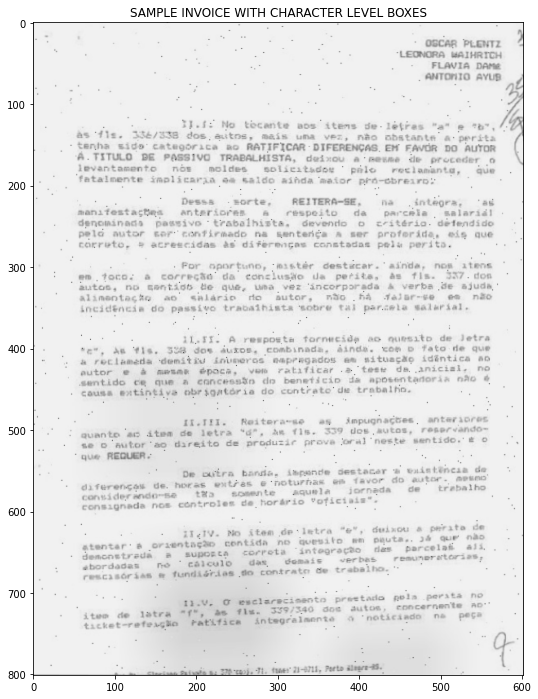

In [248]:
crappy_image = crappy_pipeline(img)
plt.figure(figsize=(16,12))
plt.imshow(crappy_image, cmap='gray')
plt.title('SAMPLE INVOICE WITH CHARACTER LEVEL BOXES')
plt.show()

# cv2.imwrite('CRAPPY_V2_TEST.png', crappy_image)

## Building crappy images

In [249]:
image_paths = glob('./is_ocr_images/*.jpg')
count = 0
current_line = 0
times = 0
print('[{}] Info: Pipeline has started. Ammount of data: {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), len(image_paths)))
for path in image_paths:
    try:
        current_line += 1
        count += 1
        if count == 1000:
            times += 1
            print('[{}] Info: Pipeline has processed and generated {} crappy images.'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), times * count))
            count = 0
        image_name = re.sub('^\.\/is_ocr_images\/', '', path)
        current_image = cv2.imread(path)
        crappy_image = crappy_pipeline(current_image)
        cv2.imwrite('./crappy_images_v2/crappy_{}'.format(image_name), crappy_image)
    except Exception as err:
        print('[{}] Error: Error in {} line (consuming image {})'.format(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), current_line, image_name))
        print(err)
    

[2020-11-09 22:45:45] Info: Pipeline has started. Ammount of data: 80624
[2020-11-09 22:46:48] Info: Pipeline has processed and generated 1000 crappy images.
[2020-11-09 22:47:51] Info: Pipeline has processed and generated 2000 crappy images.
[2020-11-09 22:48:56] Info: Pipeline has processed and generated 3000 crappy images.
[2020-11-09 22:50:00] Info: Pipeline has processed and generated 4000 crappy images.
[2020-11-09 22:51:05] Info: Pipeline has processed and generated 5000 crappy images.
[2020-11-09 22:52:10] Info: Pipeline has processed and generated 6000 crappy images.
[2020-11-09 22:53:15] Info: Pipeline has processed and generated 7000 crappy images.
[2020-11-09 22:54:20] Info: Pipeline has processed and generated 8000 crappy images.
[2020-11-09 22:55:27] Info: Pipeline has processed and generated 9000 crappy images.
[2020-11-09 22:56:34] Info: Pipeline has processed and generated 10000 crappy images.
[2020-11-09 22:57:43] Info: Pipeline has processed and generated 11000 crapp

'2019-11-06 21:15:08'